At first, use maybe want to use again the following code:

In [1]:
function binary(z,N)
    x=log(z)/log(2)
    digits=N

    bin_zahl=zeros(Int,digits)
    for i in 1:digits
        rest  =rem(z,2)
        bin_zahl[digits+1-i]=rest
        z=div(z,2)
    end

    return bin_zahl
end

function trafo(x)
    return x-0.5
end

function spin_state_generator(N)
states=[ ]                                #empty array
for i in 0:2^N -1                 
    state=trafo(binary(i,N))
    push!(states,state)                    #if possible state has exactly M particles, it is accepted

end
    return states
end



spin_state_generator (generic function with 1 method)

In [2]:
function RandomState(M)
    state=Array{Float64}(0)

    for i in 1:2^M
        z=2*rand(1)[1]-1
        push!(state,z)
    end

    return state/norm(state)
end

RandomState (generic function with 1 method)

In general: this task lengthy and one has to do a lot of bookkeeping to implemenet it right. It is useful to divide this tasks in several small tasks, putting them together in the end.

# Decomposition 

At first, I would recommend to write a function $decomposition(M,Ma,Mb)$ which just displays for a system with $M$ spins, how the spin states get distributed in the decomposition of the system in subsystem $M_A$ and $M_B$. As an example, a state in system $M$ in general is given by:

$\mid \psi \rangle = a_0 \mid \downarrow \downarrow \downarrow \rangle + a_1 \mid \downarrow \downarrow \uparrow \rangle + a_2 \mid \downarrow \uparrow \downarrow \rangle + a_3 \mid \downarrow \uparrow \uparrow \rangle + a_4 \mid \uparrow \downarrow \downarrow \rangle +a_5 \mid \uparrow \downarrow \uparrow \rangle a_6 \mid \uparrow \uparrow \downarrow \rangle + a_7 \mid \uparrow \uparrow \uparrow \rangle$

Which in corresponds to a state in binary basis:

$\mid \psi \rangle = a_0 \mid 0 \rangle + a_1 \mid 1 \rangle + a_2 \mid 2 \rangle + a_3 \mid 3 \rangle + a_4 \mid 4 \rangle +a_5 \mid 5 \rangle a_6 \mid 6 \rangle + a_7 \mid 7 \rangle$

Decomposing the initial system with $M=3$ into two subsystems $M_A=2$ and $M_B=1$ leads to:

$\mid \psi \rangle = a_0 \mid \downarrow \downarrow \rangle_A \mid \downarrow \rangle_B + a_1 \mid \downarrow \downarrow \rangle_A \mid \uparrow \rangle_B + a_2 \mid \downarrow \uparrow \rangle_A \mid \downarrow \rangle_B + a_3 \mid \downarrow \uparrow \rangle_A \mid \uparrow \rangle_B + a_4 \mid \uparrow \downarrow \rangle_A \mid  \downarrow \rangle_B +a_5 \mid \uparrow \downarrow \rangle_A \mid \uparrow \rangle_B + a_6 \mid \uparrow \uparrow \rangle_A \mid \downarrow \rangle_B + a_7 \mid \uparrow \uparrow \rangle_A \mid \uparrow \rangle_B$

And now the states in subsystem A and B are labeled corresponding their binary basis:

$\mid \psi \rangle = a_0 \mid 0 \rangle_A \mid 0\rangle_B + a_1 \mid 0 \rangle_A \mid 1 \rangle_B + a_2 \mid 1 \rangle_A \mid 0 \rangle_B + a_3 \mid 1 \rangle_A \mid 1 \rangle_B + a_4 \mid 2 \rangle_A \mid  0 \rangle_B +a_5 \mid 2 \rangle_A \mid 1 \rangle_B + a_6 \mid 3 \rangle_A \mid 0 \rangle_B + a_7 \mid 3 \rangle_A \mid 1\rangle_B$

From this procedure, we can set up list to see what states in subsystem A and B are corresponding to a state in the whole system (with an additional empty column):

     1.0  1.0  1.0  0.0 
     2.0  1.0  2.0  0.0
     3.0  2.0  1.0  0.0
     4.0  2.0  2.0  0.0
     5.0  3.0  1.0  0.0
     6.0  3.0  2.0  0.0
     7.0  4.0  1.0  0.0
     8.0  4.0  2.0  0.0

Now we can decompose a state with the help of the fourth empty column. Example state: <br\>
$\mid \phi \rangle =\mid 6 \rangle + \mid 2 \rangle=\mid \uparrow \uparrow \downarrow \rangle + \mid \downarrow \uparrow \downarrow \rangle 
= \mid \uparrow \uparrow \rangle_A \mid \downarrow \rangle_B + \mid \downarrow \uparrow \rangle_A \mid \downarrow \rangle_B=
 \mid 3 \rangle_A \mid 0\rangle_B  + \mid 1 \rangle_A \mid 0 \rangle_B$

Therefore we would represent this state with the decomposition:

     1.0  1.0  1.0  0.0 
     2.0  1.0  2.0  0.0
     3.0  2.0  1.0  1
     4.0  2.0  2.0  0.0
     5.0  3.0  1.0  0.0
     6.0  3.0  2.0  0.0
     7.0  4.0  1.0  1
     8.0  4.0  2.0  0.0

Caution: we describe the states in binary  (therefore state $\mid 0 \rangle$ exists), but because the counting in Julia begins with 1 and not 0, the states in the decomposition are shifted, i.e. $\mid 0 \rangle$ is labeled as $1$, $\mid 1 \rangle$ is labeled as $2$ etc.

# Density operator

Reminder: the density operator is defined via: <br\>
$\rho = \mid \psi \rangle \langle \psi \mid$

For a general state, this will get huge. If we take the former general state for $M=3$:

$\mid \psi \rangle = a_0 \mid 0 \rangle_A \mid 0\rangle_B + a_1 \mid 0 \rangle_A \mid 1 \rangle_B + a_2 \mid 1 \rangle_A \mid 0 \rangle_B + a_3 \mid 1 \rangle_A \mid 1 \rangle_B + a_4 \mid 2 \rangle_A \mid  0 \rangle_B +a_5 \mid 2 \rangle_A \mid 1 \rangle_B + a_6 \mid 3 \rangle_A \mid 0 \rangle_B + a_7 \mid 3 \rangle_A \mid 1\rangle_B$

Then we are getting for $\rho$:

$\rho = a_0 a_0 \mid 0 \rangle_A \mid 0\rangle_B \langle 0 \mid_A \langle 0 \mid_B + \ 
a_0 a_1 \mid 0 \rangle_A \mid 0\rangle_B \langle 0 \mid_A \langle 1 \mid_B 
+ \dots
+ a_7 a_7 \mid 3 \rangle_A \mid 1\rangle_B \langle 3 \mid_A \langle 1 \mid_B$

In total $8\cdot8=64$ terms. My idea is, to write this with the aforementioned framework via an array like this:

     1.0  1.0  1.0  1.0   0
     1.0  1.0  1.0  2.0   0
     1.0  1.0  2.0  1.0   0
     1.0  1.0  2.0  2.0   0
     1.0  1.0  3.0  1.0   0
     1.0  1.0  3.0  2.0   0
     1.0  1.0  4.0  1.0   0
     1.0  1.0  4.0  2.0   0
     1.0  2.0  1.0  1.0   0
     1.0  2.0  1.0  2.0   0
     1.0  2.0  2.0  1.0   0
     1.0  2.0  2.0  2.0   0
     1.0  2.0  3.0  1.0   0
    ...

Where the first four columns represent: $\mid i \rangle_A \mid j\rangle_B \langle m \mid_A \langle n \mid_B $ and the last one has to be filled with the product $a_j \cdot a_k$. This means for the example state from the decomposition:

$\mid \phi \rangle =\mid 3 \rangle_A \mid 0\rangle_B  + \mid 1 \rangle_A \mid 0 \rangle_B$

$\rho= \mid \phi \rangle \langle \phi \mid =\left( \mid 3 \rangle_A \mid 0\rangle_B  + \mid 1 \rangle_A \mid 0 \rangle_B \mid \right)  
\left( \langle 3 \mid_A \langle 0\mid_B  + \langle 1 \mid_A \langle 0 \mid_B \right)$

$\rho=\mid 3 \rangle_A \mid 0\rangle_B \langle 3 \mid_A \langle 0\mid_B \ + \ \mid 3 \rangle_A \mid 0\rangle_B \langle 1 \mid_A \langle 0\mid_B \ + \ \mid 1 \rangle_A \mid 0\rangle_B \langle 3 \mid_A \langle 0\mid_B + \mid 1 \rangle_A \mid 0\rangle_B \langle 1 \mid_A \langle 0\mid_B$

Therefore in the mentioned representation they are four non-zero entires:

     4.0  1.0  4.0  1.0   1
     4.0  1.0  2.0  1.0   1
     2.0  1.0  4.0  1.0   1
     2.0  1.0  2.0  1.0   1

# Reduced Density Matrix

Remeber how the $Tr_B$ operator acts: $Tr_B (\rho)=\sum_{i}\langle i \mid_B \rho \mid i \rangle_B$

Therefore only components like $\mid n \rangle_A \mid k\rangle_B \langle m \mid_A \langle k\mid_B$ (where the B-states are identical) can survive in this procedure. We go directly to the matirx representation of the reduced density operator i.e. $\mid n \rangle_A \mid k\rangle_B \langle m \mid_A \langle k\mid_B$ after applying $Tr_B$ creates an entry in the matrix $\hat{\rho}$ in $\hat{\rho}_{n,m}$

For the example state in the list representation:

     4.0  1.0  4.0  1.0   1
     4.0  1.0  2.0  1.0   1
     2.0  1.0  4.0  1.0   1
     2.0  1.0  2.0  1.0   1

This means that all four components of $\rho$ will contribute: we will get matrix entries at $(4,4), (4,2), (2,4)$ and $(2,2)$. The total dimension of the matrix $\hat{\rho}$ is $2^{M_A} \times 2^{M_A}$, corresponding from the total amount of different states in subsystem A$. The matrix for our example state is then:

$
\begin{pmatrix}
0 & 0 & 0 & 0 \\
0 & 1 & 0 &1 \\
0 & 0& 0 & 0 \\
0& 1 & 0 & 1
\end{pmatrix}
$  

(Our initial state was not normalized to 1. In general you had to do this)

# Entropy 

Finally you have to calculate the entropy. This is just done by calculating the eigenvalues $\lambda_i$ of the aforementioned matrix and use the definition:

$S=- \sum_i \lambda_i \log (\lambda_i)$

If you choose the base of the logarithm to be equal to amount of states in the subsystem (i.e. $2^{M_A}$) you can also implement a normalization: the most entangled state will then have $S=1$

Caution: for $\lambda_i=0$ you will get zero for $\lambda_i \log (\lambda_i)$. But you will get an error because you try to feed the logarithm with a 0 too. Here you should implement some kind of $if$-loop to avoid this problem.

# Appendix: a heuristic interpretation of the entropy

What is entanglement, really? A heuristic interpretation for this phenomenon is understand it in terms of the changing of measurement outcomes. For example, take the following state: <br\>
$\mid \psi \rangle = \frac{1}{\sqrt{2}} \left( \mid \uparrow \downarrow \rangle + \mid \downarrow \uparrow \rangle \right) $

We may ask the following questions: <br\>
What is the probability of measuring spin-up / spin-down for spin 1? <br\>
What is the probability of measuring spin-up / spin-down for spin 2? <br\>
<br\>
Obviously the answer in both cases is 50 percent. But now imagine the following: I measure spin 1 at first and measured a spin-up. Then the state $\mid \psi \rangle$ collapses into the subspace with spin 1 up, meaning after measurement I am left over with: <br\>
$\mid \psi \rangle = \mid \uparrow \downarrow \rangle$ <br\>
What is now the probability of measuring spin-up / spin-down for spin 2? Obviously it is 0 percent for spin-up and 100 percent for spin-down. Therefore the probabilities for this measurement have changed just by measuring another observable before. We can therefore (in a hand-waving manner) see entanglement as the ability how strong the measurement of one observable changes the outcomes of another observable.

But what is the meaning of the entropy and why does it quantify entanglement? For a better understand, we forget firstly about entanglement itself and deal with classical probabilities, because the entropy (here called Shannon-entropy) can also be defined here. 

The Shannon-entropy is defined via: $S=-\sum_{i} p_i \log{p_i}$, where $p_i$ are the classical probabilities of an experiment e.g. a coin toss.

We understand the entropy as a measurement of $\textit{information}$, which we can also hand-wavingly understand as the answer to the question: "how much knowledge do I gain after performing an experiment?"

We use the coin toss example know. Both outcomes, heads and tails, have a probability of 50 $percent$. Therefore $p_{heads}=p_{tails}=0.5$. We normalize the logarithmic by setting the base to 2 (amount of different outcomes) and calculate:

$S=-0.5\log_2(0.5) - 0.5\log_2(0.5)= -log_2(0.5)=log_2(2)=1$

Which is the maximal information. To interpret this example, we now say, that the coin can be manipulated. We can set the probability of $p_{heads}$ freely, such that $p_{tails}=1-p_{heads}$.

$S=-p_{heads}\log_2(p_{heads}) - (1-p_{heads})\log_2(1-p_{heads})$

Plotting this:

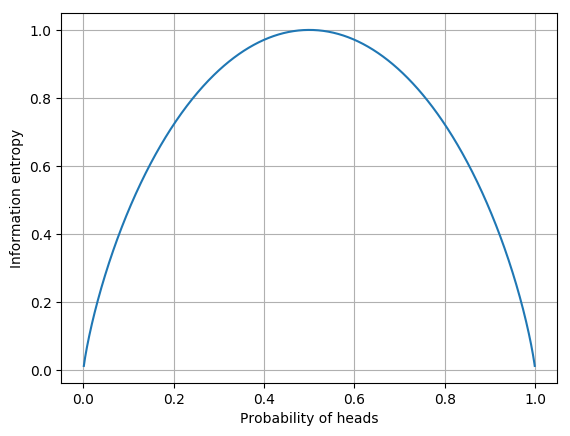

In [29]:
using PyPlot
S(p)=-p*log(2,p)-(1-p)log(2,1-p)
pdata=collect(0.001:0.001:0.999)
sdata=zeros(length(pdata))
for i in 1:length(sdata)
    sdata[i]=S(pdata[i])
end

plot(pdata,sdata)
xlabel("Probability of heads")
ylabel("Information entropy")
grid()

So the maxium is indeed at $p_{heads}=0.5$, the fair coin. We mentioned to interpret information as the answer to the question "how much knowledge do I gain after the experiment?". So this makes sense. In the case of the fair coin, where both proabilities are 50 percent, we cannot predict the outcome because both events are equally likely. After performing the experiment and then getting your result of the coin toss, you know something which you could not predict with a good accuracy. <br\>

Imaging another extreme case, like $p_{heads}=0.99$ and $p_{tails}=0.01$. Here you can pretty predict the outcome of the event very well. When there is a $99$ percent chance that you are getting heads you will not gain much information about the situation  after the experiment because you "nearly" already know what the outcome will be. <br\>
<br\>
This interpretation is not rock solid, but helps to build up a general understanding for the entropy as an information measurement.

Now back to entanglement. <br\>
Since we already stressed the notion, that the entanglement is rougly the changing of the outcomes of a measurement by another measurement we interpret the entanglement as the answer to the question:<br\>
"how much is my knowledge about system $B$ changed after I perform a measurement on system $A$?

Taking the reduced density matrices from sheet 4, exercise 4 as example:

a) <br\>
$\mid \psi \rangle = \mid \uparrow \rangle_A \mid \downarrow \rangle_B$ <br\>
$
\hat{\rho}=
\begin{pmatrix}
1 & 0  \\
0 & 0  \\
\end{pmatrix}
$  
<br\>
Eigenvalues: $\lambda_1=1$ $\lambda_2=0$ $\rightarrow$ $S=0$

The entropy is zero. Before measuring system B the propabilities for system A a 100 percent for spin-up and 0 percent for spin-down. This does not change when spin B is measured. Therefore we have no entanglement.

b) <br\>
$\mid \psi \rangle = \frac{1}{\sqrt{2}} \left( \mid \uparrow \rangle_A \mid \downarrow \rangle_B- \mid \downarrow \rangle_A \mid \uparrow \rangle_B \right) $

<br\>
$
\hat{\rho}=
\begin{pmatrix}
1/2 & 0  \\
0 & 1/2  \\
\end{pmatrix}
$  
<br\>
Eigenvalues: $\lambda_1=1/2$ $\lambda_2=1/2$ $\rightarrow$ $S=1$

The entropy is at maximmal value. Before measuring spin B, we can get with a 50 percent chance either spin-up or spin-down for spin A. After measuring B this collapses to either 100 percent spin-up or 100 percent spin-down, depending on what was measured on spin B. That means: before the measurement spin A could acces the whole space (the two basis states) with equal probability and after the measurement it is reduced to only one outcome. This is a maximal altering of the outcomes and results in the maximal value of the entropy.

c) <br\>
$\mid \psi \rangle = \frac{1}{2} \left( \mid \uparrow \rangle_A \mid \downarrow \rangle_B+ \mid \downarrow \rangle_A \mid \uparrow \rangle_B +\mid \downarrow \rangle_A \mid \downarrow \rangle_B + \mid \uparrow \rangle_A \mid \uparrow \rangle_B\right) $
<br\>
$
\hat{\rho}=
\begin{pmatrix}
1/2 & 1/2  \\
1/2 & 1/2  \\
\end{pmatrix}
$  
<br\>
After diagonalization: Eigenvalues: $\lambda_1=1$ $\lambda_2=0$ $\rightarrow$ $S=0$

At first the probability of spin-up or spin-down for spin A is 50 percent each. After measuring spin B the state collapses to the following state regardless of what was measured for spin B: <br\>
$\mid \tilde{\psi} \rangle= \frac{1}{2} \left(\mid \downarrow \rangle_A + \mid \uparrow \rangle_A \right)$ <br\>

And here the probabilities of spin A are not changed at all. Therefore the state is not entangled and 0 entropy is expected.

At last an example with another decomposition of the spaces. Let's take this normalized example state from:

$\mid \phi \rangle =\frac{1}{\sqrt{2}} \left( \mid \uparrow \uparrow \downarrow \rangle + \mid \downarrow \uparrow \uparrow \rangle \right)$

We divide again into $M_A=2$ and $M_B=1$ and investigate the entanglement between these subspaces:

$\mid \phi \rangle =\frac{1}{\sqrt{2}} \left( \mid \uparrow \uparrow \rangle_A \mid \downarrow \rangle_B + \mid \downarrow \uparrow \rangle_A \mid \uparrow \rangle_B \right)$

The probability for getting $ \mid \uparrow \uparrow \rangle_A$ is 50 percent before measuring B which holds also true for the probability of state $ \mid \downarrow \uparrow \rangle_A$. After measuring B one is left with either of one of those states, which gains then a 100 percent probability for measuring A. How does this reflect in the entropy?

The reduced density matrix is (as one can check): <br\>

$
\hat{\rho}=
\begin{pmatrix}
0 & 0 & 0 & 0  \\
0 & 1/2 & 0 & 0 \\
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 1/2 \\
\end{pmatrix}
$  

So the eigenvalues are $\lambda_1=0$, $\lambda_2=0.5$, $\lambda_3=0$, $\lambda_4=0.5$ The entanglement entropy (with the logarithm normalized with base 4 now) results into: $S=0.5$

Therefore we have definitely entanglement, but not maxmial entanglement. Why is this so? In example b) we had maximal entanglement. Here one could measure ANY state of basis $A$ in System $A$ before the measurement on $B$ and after the measurment on $B$ only one state of basis $A$ could be measured, reducing the outcomes totally. But in our new example here, the system $A$ can only take 2 of the 4 basis states of $A$ (the states $ \mid \downarrow \downarrow \rangle_A$ and $ \mid \uparrow \downarrow \rangle_A$ are not measurable in the beginning). So after measuring $B$ the measurment of $A$ is reduced from two possible states on equal footing to only one possible state. A maximal entanglement would requiere that the measurement gets reduced from all 4 possible states to only one state. Rougly speaking, this state is not maxmially entangled because they are still more extreme reductions of probabilities possible for other states (namely with all four states). Since we reduce the system not from all states to one state measurable but from the half of all states to one state measureable, we expect half of the maximal entanglement, which results into $S=0.5$.